## Progression of selfplay games
Scores are min_move_dead
* Games 0 to 200: Fixed move order L,U,D,R
* Games 200 to 400: `20200126/soft3.5_20_200_c64b3_p10_bs2048lr0.08d0.0_s4_best`
* Games 400 to 600: `20200128/20_400_soft3.5c64b3_p10_bs2048lr0.08d0.0_s2pre_best`
* Games 600 to 800: `20200130/0_600_soft3.5c64b3_p10_bs2048lr0.08d0.0_s7pre_best`

In [1]:
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
os.chdir('../selfplay/')

In [2]:
def get_max(x):
    tiles = []
    for _ in range(16):
        tiles.append(x & 0xF)
        x >>= 4
    return max(tiles)

In [3]:
indices = []
moves = []
scores = []
tiles = []
move_dir = []
i = 0
while True:
    try:
        x = np.load(str(i).zfill(5)+'.npz')
        indices.append(i)
        moves.append(len(x['boards']))
        scores.append(x['score'])
        tiles.append(get_max(x['boards'][-1].item()))
        move_dir.append(np.argsort(x['results'], axis=1)[:, -1])
        i += 1
    except FileNotFoundError:
        print('Got {} games'.format(i))
        break
blocks = (i-1)//200 + 1

Got 800 games


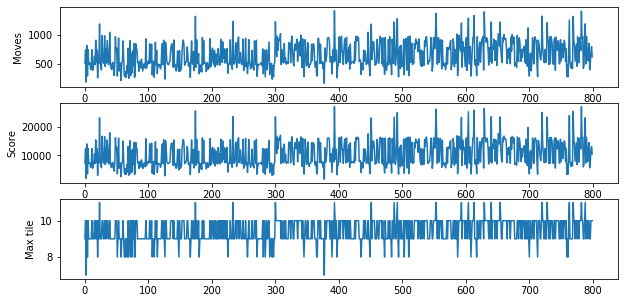

In [4]:
plt.subplots(figsize=(10, 5))
plt.subplot(311)
plt.plot(indices, moves)
plt.ylabel('Moves')
plt.subplot(312)
plt.plot(indices, scores)
plt.ylabel('Score')
plt.subplot(313)
plt.plot(indices, tiles)
plt.ylabel('Max tile')
plt.show()

Scores and tiles are slowly increasing with each network iteration.

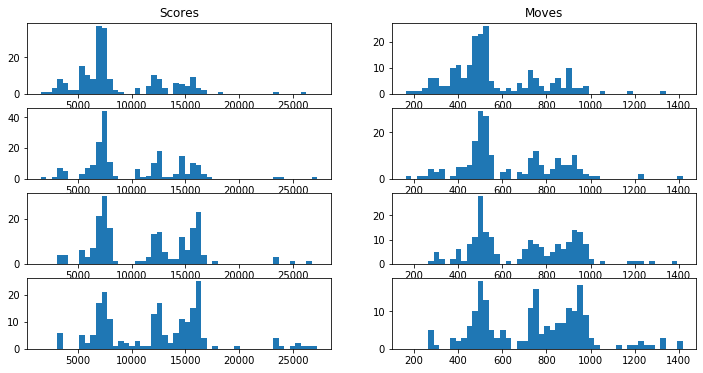

In [5]:
xscore = (min(scores), max(scores))
xmoves = (min(moves), max(moves))
plt.figure(figsize=(12,6))
for i in range(blocks):
    plt.subplot(blocks, 2, 1+2*i)
    plt.hist(scores[200*i:200*(i+1)], range=xscore, bins=50)
    if not i: plt.title('Scores')
    plt.subplot(blocks, 2, 2+2*i)
    plt.hist(moves[200*i:200*(i+1)], range=xmoves, bins=50)
    if not i: plt.title('Moves')
plt.show()

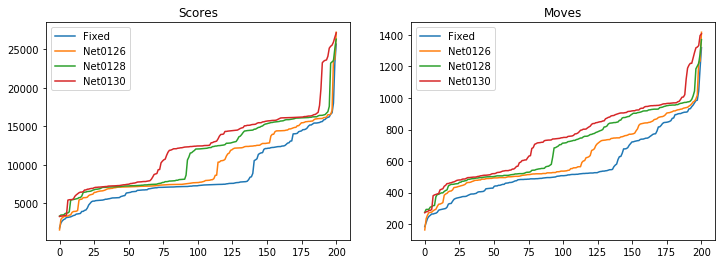

In [6]:
names = ['Fixed','Net0126','Net0128', 'Net0130']
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for i in range(blocks):
    plt.plot(np.linspace(0, 200, len(moves[200*i:200*(i+1)])), 
             sorted(scores[200*i:200*(i+1)]))
plt.title('Scores')
plt.legend(names)
plt.subplot(1,2,2)
for i in range(blocks):
    plt.plot(np.linspace(0, 200, len(moves[200*i:200*(i+1)])), 
             sorted(moves[200*i:200*(i+1)]))
plt.title('Moves')
plt.legend(names)
plt.show()

In [7]:
i = blocks - 2
print(f'Testing between block #{i+1} and #{i+2}')
print('-'*10)

# Test if sample means are the same
print(stats.ttest_ind(scores[200*i:200*(i+1)], scores[200*(i+1):200*(i+2)], equal_var=False))
print(stats.ttest_ind(moves[200*i:200*(i+1)], moves[200*(i+1):200*(i+2)], equal_var=False))
print('-'*10)

# Test if samples are drawn from the same distribution
print(stats.ks_2samp(scores[200*i:200*(i+1)], scores[200*(i+1):200*(i+2)]))
print(stats.ks_2samp(moves[200*i:200*(i+1)], moves[200*(i+1):200*(i+2)]))
print('-'*10)

# Test if variances are the same
print(stats.bartlett(scores[200*i:200*(i+1)], scores[200*(i+1):200*(i+2)]))
print(stats.bartlett(moves[200*i:200*(i+1)], moves[200*(i+1):200*(i+2)]))

Testing between block #3 and #4
----------
Ttest_indResult(statistic=-2.2301624932010227, pvalue=0.026297793311070537)
Ttest_indResult(statistic=-2.149168191020203, pvalue=0.03222637071178006)
----------
Ks_2sampResult(statistic=0.12, pvalue=0.11228360286766195)
Ks_2sampResult(statistic=0.12, pvalue=0.11228360286766195)
----------
BartlettResult(statistic=1.4863038844643899, pvalue=0.22279081973791712)
BartlettResult(statistic=0.949980907822273, pvalue=0.3297241571094426)


# Move distribution

In [8]:
import pandas as pd
import seaborn as sns

In [9]:
sns_moves = pd.DataFrame(columns=['group','Left','Up','Right','Down'])
groups = []
for n in names:
    groups.extend([n]*200)
for m, g in zip(move_dir, groups):
    hist = np.histogram(m, bins=np.arange(5), density=True)[0]
    sns_moves = sns_moves.append({'group': g,
                                  'Left': hist[0],
                                  'Up': hist[1],
                                  'Right': hist[2],
                                  'Down': hist[3]},
                                  ignore_index=True)

In [10]:
sns_moves = pd.melt(sns_moves, id_vars='group', var_name='move', value_name='percent')

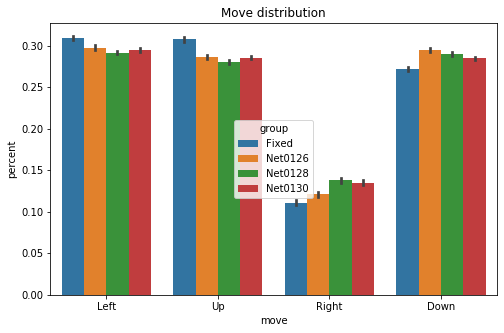

In [11]:
# Note: seaborn error bars are 95% CI of mean
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='move', y='percent', hue='group', data=sns_moves)
ax.set_title('Move distribution')
plt.show()

Down moves are increased. Right moves are increasing. Should I be concerned about lack of symmetry breaking between L,U,D?